In [1]:
import pandas as pd
import numpy as np
from matplotlib import colors, cm, text, pyplot as plt
import matplotlib.patches as patches

In [2]:
raw_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/YHE211_1-mz-748-766-rt-2000-2200.pkl')
raw_df[(raw_df.frame_type == 0) & (raw_df.retention_time_secs >= 2054) & (raw_df.retention_time_secs <= 2055)].frame_id.unique()

array([18427, 18432])

In [3]:
raw_df = raw_df[(raw_df.frame_id == 18427) & (raw_df.intensity >= 50)]

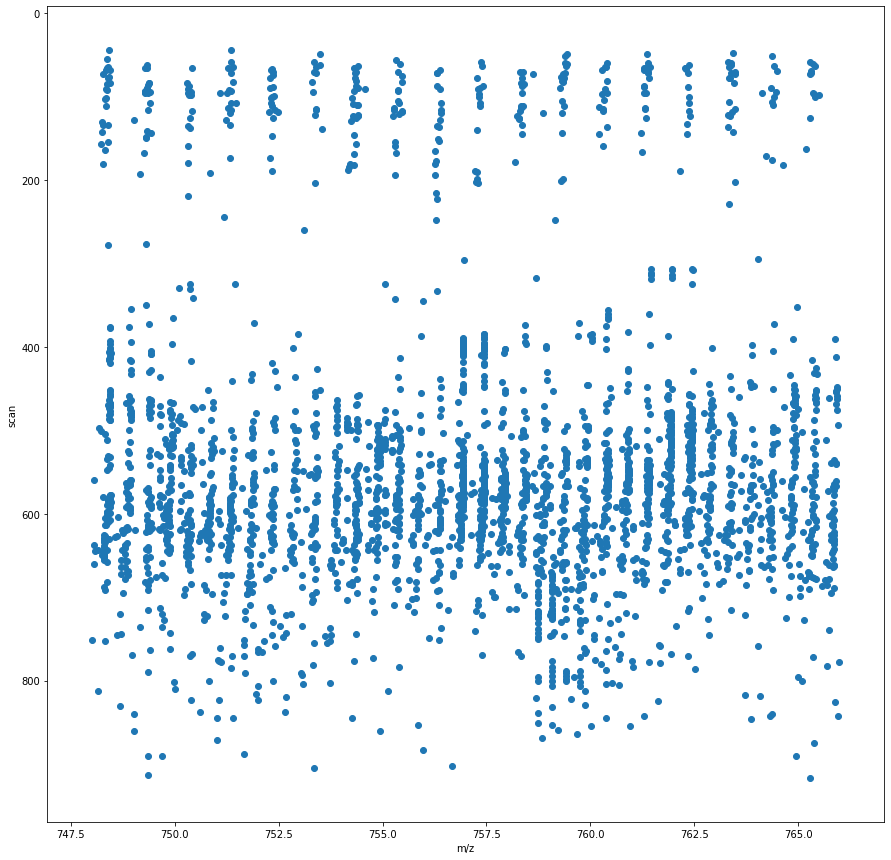

In [4]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(raw_df.mz, raw_df.scan)

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [5]:
# find the most intense point
intensity_max_idx = raw_df.intensity.idxmax()

In [6]:
intensity_max_idx

1254249

In [7]:
candidate_peak_s = raw_df.loc[intensity_max_idx]

In [8]:
mz_lower = candidate_peak_s.mz - 1.0
mz_upper = candidate_peak_s.mz + 7.0
scan_lower = candidate_peak_s.scan - 50
scan_upper = candidate_peak_s.scan + 50

In [45]:
candidate_region_df = raw_df[(raw_df.mz >= mz_lower) & (raw_df.mz <= mz_upper) & (raw_df.scan >= scan_lower) & (raw_df.scan <= scan_upper)].copy()

In [46]:
MS1_PEAK_DELTA = 0.1

In [47]:
peak_mz_lower = candidate_peak_s.mz-MS1_PEAK_DELTA
peak_mz_upper = candidate_peak_s.mz+MS1_PEAK_DELTA

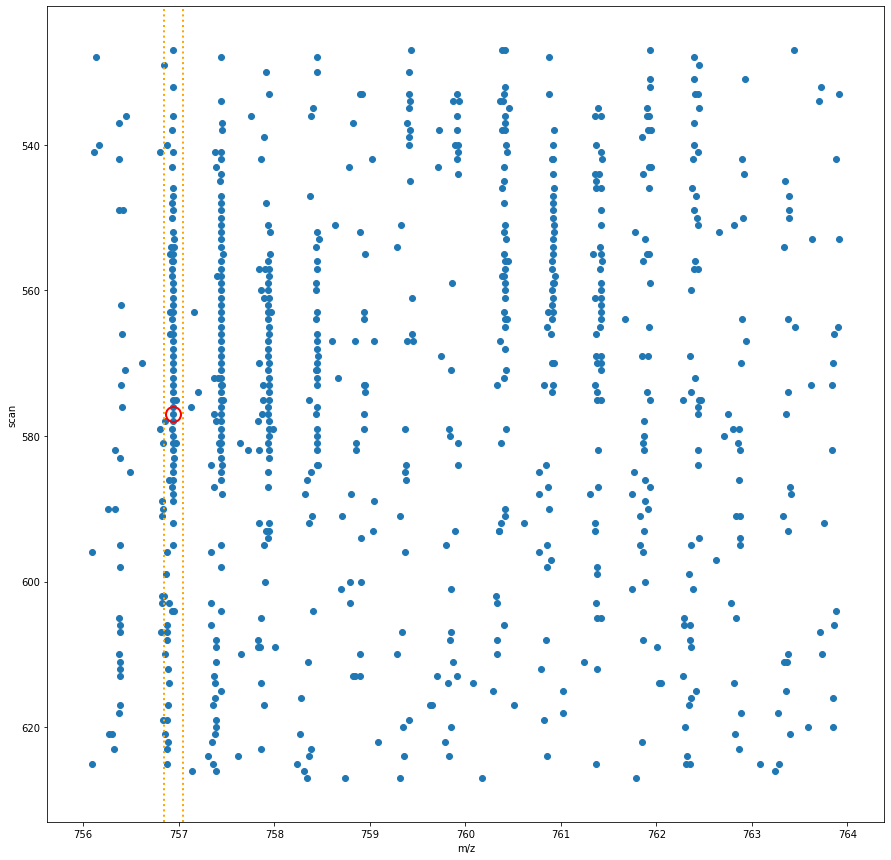

In [48]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(candidate_region_df.mz, candidate_region_df.scan)
plt.plot(candidate_peak_s.mz, candidate_peak_s.scan, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15, label='anchor point')

plt.axvline(x=peak_mz_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=peak_mz_upper, linestyle=':', color='orange', linewidth=2)

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [49]:
peak_df = candidate_region_df[(candidate_region_df.mz >= peak_mz_lower) & (candidate_region_df.mz <= peak_mz_upper)]

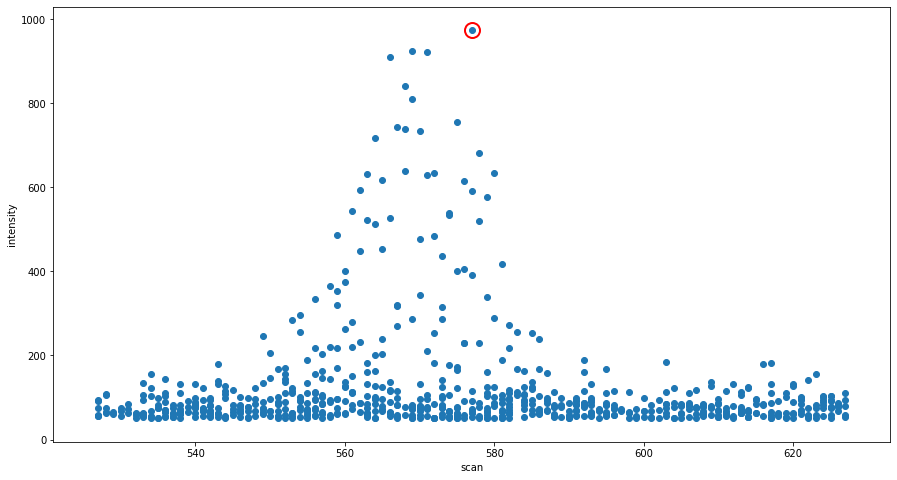

In [50]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(candidate_region_df.scan, candidate_region_df.intensity)
plt.plot(candidate_peak_s.scan, candidate_peak_s.intensity, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15, label='anchor point')

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

#### segment the raw data to reveal the isotopes in the feature

In [51]:
PIXELS_X = 1000
PIXELS_Y = 1000
MZ_MIN = candidate_region_df.mz.min()
MZ_MAX = candidate_region_df.mz.max()
SCAN_MIN = candidate_region_df.scan.min()
SCAN_MAX = candidate_region_df.scan.max()
PIXEL_PER_MZ = PIXELS_X / (MZ_MAX - MZ_MIN)
PIXEL_PER_SCAN = PIXELS_Y / (SCAN_MAX - SCAN_MIN)
MZ_PER_PIXEL = 1 / PIXEL_PER_MZ
SCAN_PER_PIXEL = 1 / PIXEL_PER_SCAN

In [52]:
PIXEL_PER_MZ, PIXEL_PER_SCAN

(127.92980876199985, 10.0)

In [53]:
MZ_PER_PIXEL, SCAN_PER_PIXEL

(0.00781678648375373, 0.1)

In [54]:
def tile_pixel_x_from_mz(mz):
    pixel_x = int((mz - MZ_MIN) * PIXEL_PER_MZ)
    return pixel_x

def tile_pixel_y_from_scan(scan):
    pixel_y = int((scan - SCAN_MIN) * PIXEL_PER_SCAN)
    return pixel_y

In [55]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

candidate_region_df['mz_scaled'] = candidate_region_df.apply(lambda row: tile_pixel_x_from_mz(row.mz), axis=1)
candidate_region_df['scan_scaled'] = candidate_region_df.apply(lambda row: tile_pixel_y_from_scan(row.scan), axis=1)

X = candidate_region_df[['mz','scan']].values
X_scaled = candidate_region_df[['mz_scaled','scan_scaled']].values

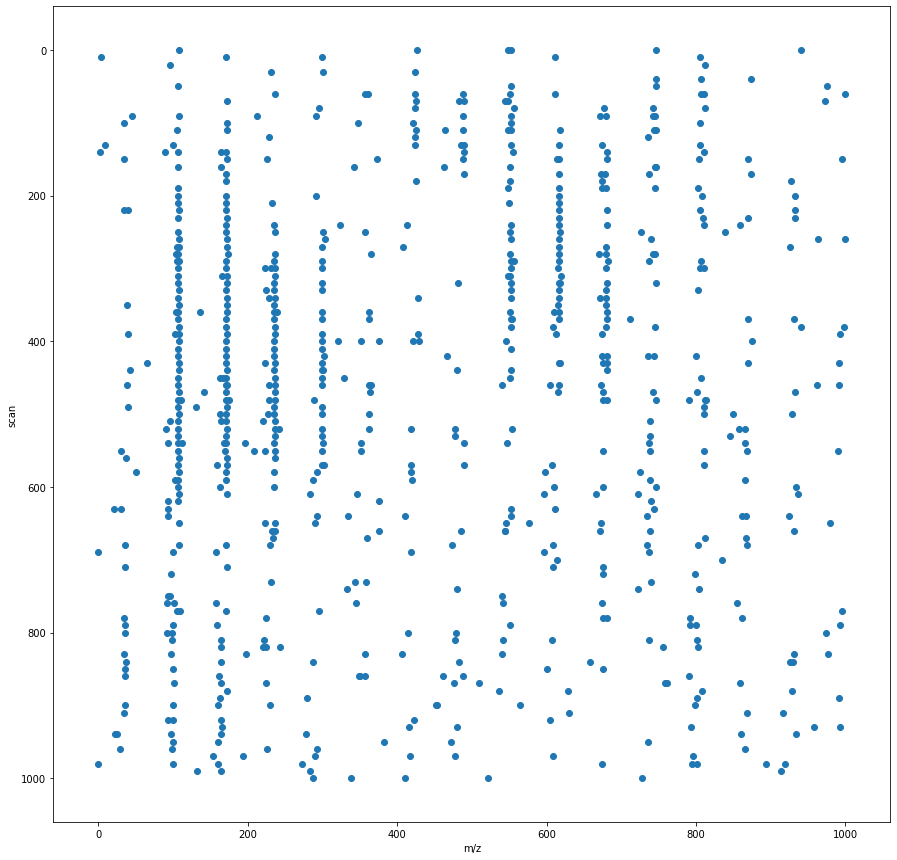

In [56]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(candidate_region_df.mz_scaled, candidate_region_df.scan_scaled)

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()

# plt.xlim([70,200])
# plt.ylim([300,200])
plt.show()

In [57]:
def custom_metric(r1, r2):
    mz_1 = r1[0]
    scan_1 = r1[1]
    mz_2 = r2[0]
    scan_2 = r2[1]
    if (abs(mz_1 - mz_2) <= 0.1) and (abs(scan_1 - scan_2) <= 2):
        result = 0.5
    else:
        result = 10
    return result;

In [58]:
# cluster the data
# dbscan = DBSCAN(eps=25, min_samples=3, metric=custom_metric)
# clusters = dbscan.fit_predict(X_scaled)

dbscan = DBSCAN(eps=1, min_samples=3, metric=custom_metric)
clusters = dbscan.fit_predict(X)

In [59]:
candidate_region_df['cluster'] = clusters

In [60]:
candidate_region_df.sample(n=5)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,mz_scaled,scan_scaled,cluster
1254255,18427,0,756.941633,585,254,2054.261605,108,580,3
1323314,18427,0,757.399065,558,89,2054.261605,166,310,9
1367937,18427,0,757.835048,608,84,2054.261605,222,810,10
1479511,18427,0,758.448226,582,111,2054.261605,300,550,14
2147090,18427,0,763.340913,554,70,2054.261605,926,270,-1


In [61]:
import peakutils

In [62]:
print('found {} clusters'.format(len(candidate_region_df.cluster.unique())))

found 58 clusters


In [63]:
colour_map = plt.get_cmap('gist_ncar')
norm = colors.Normalize(vmin=candidate_region_df.cluster.min(), vmax=candidate_region_df.cluster.max(), clip=False)

In [64]:
# calculate the cluster centroids
centroids_l = []
for group_name,group_df in candidate_region_df.groupby(['cluster'], as_index=False):
    if group_name >= 0:
        mz_centroid = peakutils.centroid(group_df.mz, group_df.intensity)
        scan_centroid = peakutils.centroid(group_df.scan, group_df.intensity)
        centroids_l.append((group_name, mz_centroid, scan_centroid))
centroids_df = pd.DataFrame(centroids_l, columns=['cluster','mz','scan'])

In [65]:
# determine a colour for each cluster
cluster_colour_l = []
for group_name,group_df in candidate_region_df.groupby(['cluster'], as_index=False):
    c = colour_map(norm(group_name), bytes=False)[:3]
    cluster_colour_l.append((group_name, c))
cluster_colour_df = pd.DataFrame(cluster_colour_l, columns=['cluster','colour'])

In [66]:
# give each point a colour
candidate_region_df = pd.merge(candidate_region_df, cluster_colour_df, how='left', left_on=['cluster'], right_on=['cluster'])


In [67]:
candidate_region_df.sample(n=3)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,mz_scaled,scan_scaled,cluster,colour
199,18427,0,757.442226,576,406,2054.261605,172,490,9,"(0.0, 0.8097972472126105, 1.0)"
332,18427,0,758.741948,627,54,2054.261605,338,1000,-1,"(0.0, 0.0, 0.502)"
157,18427,0,757.433593,545,119,2054.261605,171,180,9,"(0.0, 0.8097972472126105, 1.0)"


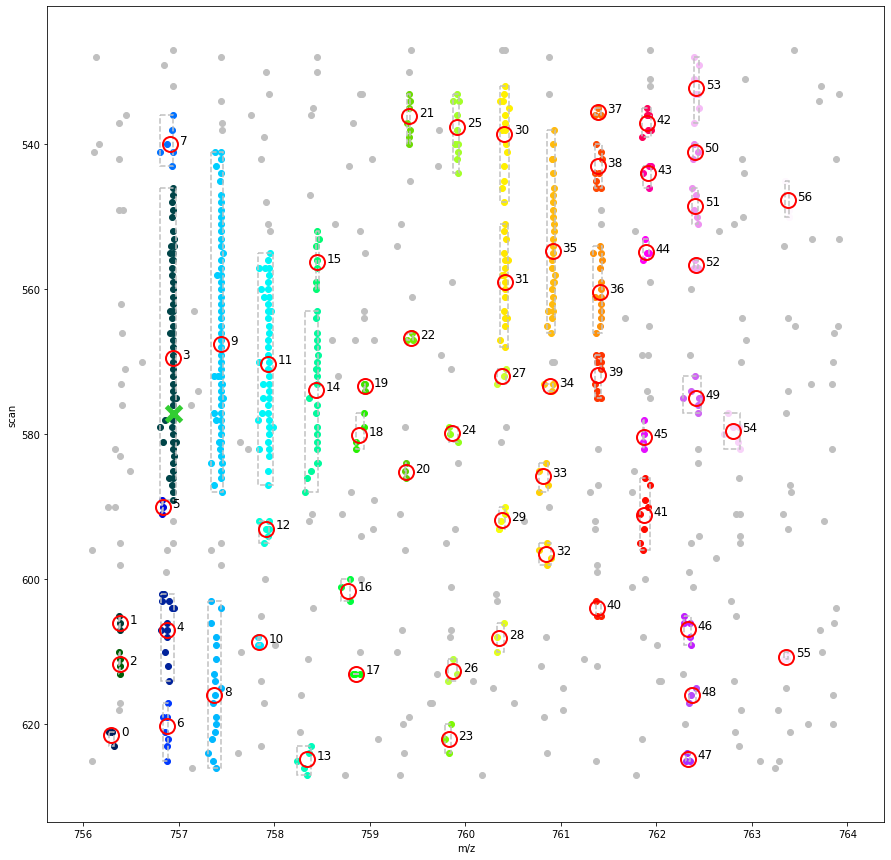

In [68]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

# plot the unassigned points
df = candidate_region_df[(candidate_region_df.cluster == -1)]
plt.scatter(df.mz, df.scan, c='silver')

df = candidate_region_df[(candidate_region_df.cluster >= 0)]
for group_name,group_df in df.groupby(['cluster'], as_index=False):
    # the raw points
    plt.scatter(group_df.mz, group_df.scan, c=np.array([group_df.iloc[0].colour]))
    # the cluster centroid
    centroid_s = centroids_df[(centroids_df.cluster == group_name)].iloc[0]
    plt.plot(centroid_s.mz, centroid_s.scan, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15)
    ax1.text(centroid_s.mz+0.1, centroid_s.scan, group_name, fontsize=12)
    # draw the cluster rectangle
    top_left = (group_df.mz.min(),group_df.scan.min())
    width = group_df.mz.max() - group_df.mz.min()
    height = group_df.scan.max() - group_df.scan.min()
    cluster_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='silver',facecolor='none')
    ax1.add_patch(cluster_rect)

# the anchor point for this candidate region
plt.plot(candidate_peak_s.mz, candidate_peak_s.scan, marker='x', markerfacecolor='none', markeredgecolor='limegreen', linestyle='', markeredgewidth=5, ms=15, label='anchor point')

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [91]:
# cluster the isotopes into series
# centroids_df['mz_scaled'] = centroids_df.apply(lambda row: tile_pixel_x_from_mz(row.mz), axis=1)
# centroids_df['scan_scaled'] = centroids_df.apply(lambda row: tile_pixel_y_from_scan(row.scan), axis=1)
centroids_df['mz_scaled'] = centroids_df.mz
centroids_df['scan_scaled'] = centroids_df.scan * 50
X_scaled = centroids_df[['mz_scaled','scan_scaled']].values

In [92]:
# cluster the data
dbscan = DBSCAN(eps=10, min_samples=3)
clusters = dbscan.fit_predict(X_scaled)
centroids_df['isotope_cluster'] = clusters

In [93]:
print('found {} isotope clusters'.format(len(centroids_df.isotope_cluster.unique())))

found 1 isotope clusters


In [89]:
candidate_region_df = pd.merge(candidate_region_df, centroids_df[['cluster','isotope_cluster']], how='left', left_on=['cluster'], right_on=['cluster'])


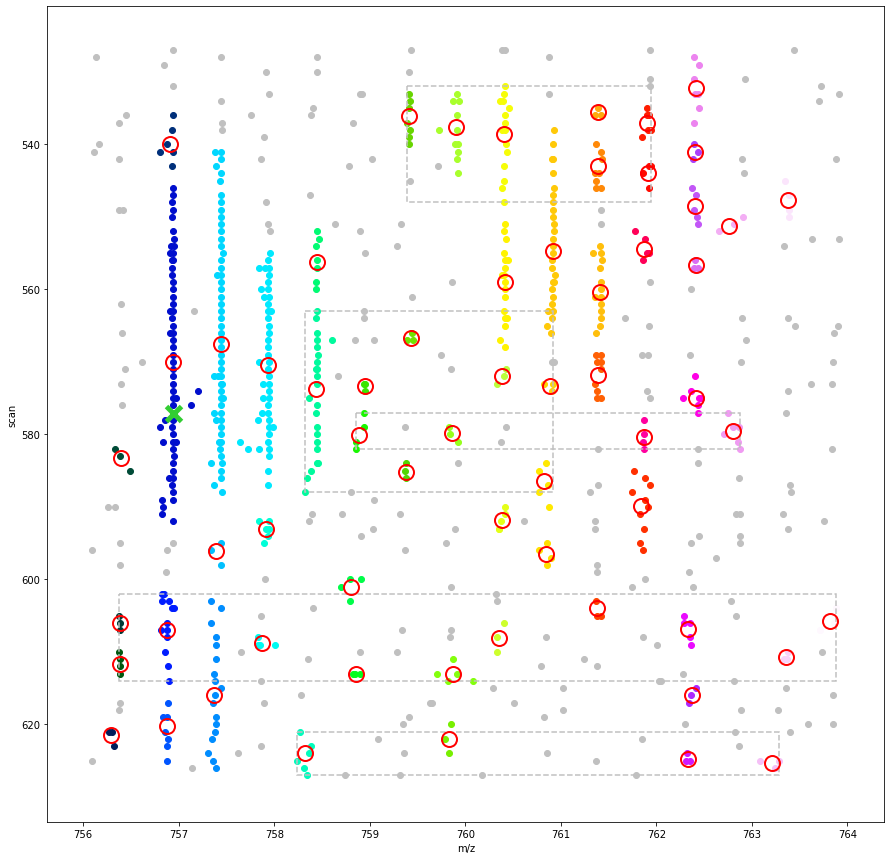

In [90]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

# plot the unassigned points
df = candidate_region_df[(candidate_region_df.cluster == -1)]
plt.scatter(df.mz, df.scan, c='silver')

df = candidate_region_df[(candidate_region_df.cluster >= 0)]
for group_name,group_df in df.groupby(['cluster'], as_index=False):
    # the raw points
    plt.scatter(group_df.mz, group_df.scan, c=np.array([group_df.iloc[0].colour]))
    # the cluster centroid
    centroid_s = centroids_df[(centroids_df.cluster == group_name)].iloc[0]
    plt.plot(centroid_s.mz, centroid_s.scan, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15)

df = candidate_region_df[(candidate_region_df.isotope_cluster >= 0)]
for group_name,group_df in df.groupby(['isotope_cluster'], as_index=False):
    # draw the cluster rectangle
    top_left = (group_df.mz.min(),group_df.scan.min())
    width = group_df.mz.max() - group_df.mz.min()
    height = group_df.scan.max() - group_df.scan.min()
    cluster_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='silver',facecolor='none')
    ax1.add_patch(cluster_rect)

# the anchor point for this candidate region
plt.plot(candidate_peak_s.mz, candidate_peak_s.scan, marker='x', markerfacecolor='none', markeredgecolor='limegreen', linestyle='', markeredgewidth=5, ms=15, label='anchor point')

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()